In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import json
import pickle

import xgboost as xgb
print("xgb.__version__:", xgb.__version__)

# local modules
import sys
sys.path.append("../src")
from preproc import process_train_data, process_test_data

xgb.__version__: 2.1.1


***
### load and preprocess data

In [2]:
# define some paths
path_raw = Path("../data/raw")
path_processed = Path("../data/processed")
path_results = Path("../data/results")

# load data
df_train = pd.read_csv(path_raw / "train.csv")
df_test = pd.read_csv(path_raw / "test.csv")

df_train

,Id,GameRulesetName,agent1,agent2,Properties,Format,Time,Discrete,Realtime,Turns,...,DoLudeme,Trigger,PlayoutsPerSecond,MovesPerSecond,EnglishRules,LudRules,num_wins_agent1,num_draws_agent1,num_losses_agent1,utility_agent1
0,0,00Y,MCTS-ProgressiveHistory-0.1-MAST-false,MCTS-ProgressiveHistory-0.6-Random200-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",4,0,11,-0.466667
1,1,00Y,MCTS-ProgressiveHistory-0.1-MAST-false,MCTS-UCB1GRAVE-0.6-NST-true,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
2,2,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1-0.1-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",7,0,8,-0.066667
3,3,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1-0.6-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
4,4,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1GRAVE-1.41421356237-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233229,233229,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-NST-false,MCTS-ProgressiveHistory-1.41421356237-Random20...,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",2,0,13,-0.733333
233230,233230,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1-0.6-MAST-false,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",9,1,5,0.266667
233231,233231,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1GRAVE-1.41421356237-NST-false,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",11,3,1,0.666667
233232,233232,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1GRAVE-1.41421356237-NST-true,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",24,2,4,0.666667


In [3]:
# input parameters
fs_type = 'fsv24'
train_type = "small"

In [4]:
# Parameters
fs_type = "fsv23"


In [5]:
# Load the feature selection results
fs_mapping = {
    "full": None,
    "fsv2": '../feat_selection/select_optuna_lgbm_v2.json',
    "fsv3": '../feat_selection/select_optuna_catb.json',
    "fsv4": '../feat_selection/select_optuna_lgbm_v3.json',
    "fsv23": '../feat_selection/select_optuna_combined_v23.json',
    "fsv24": '../feat_selection/select_optuna_combined_v24.json',
    "fsv34": '../feat_selection/select_optuna_combined_v34.json',
    "int95": '../feat_selection/feat_selection_intersection_at_95.json',
    "int96": '../feat_selection/feat_selection_intersection_at_96.json',
    "int97": '../feat_selection/feat_selection_intersection_at_97.json',
    "int98": '../feat_selection/feat_selection_intersection_at_98.json',
    "int99": '../feat_selection/feat_selection_intersection_at_99.json',
    "uni80": '../feat_selection/feat_selection_union_at_80.json',
    "uni85": '../feat_selection/feat_selection_union_at_85.json',
    "uni90": '../feat_selection/feat_selection_union_at_90.json',
    "uni95": '../feat_selection/feat_selection_union_at_95.json',
}

fs_path = fs_mapping[fs_type]

if fs_path is None:
    feature_selection = dict()
else:
    with open(fs_path, 'r') as f:
        feature_selection = json.load(f)

# Extract the selected features
numerical_cols = feature_selection.get('numerical', None)
categorical_cols = feature_selection.get('categorical', None)

# text_cols = ["LudRules",]
text_cols = list()

print("Numerical features:", len(numerical_cols) if numerical_cols else 0)
print("Categorical features:", len(categorical_cols) if categorical_cols else 0)
print("Text features:", len(text_cols) if text_cols else 0)

Numerical features: 141
Categorical features: 9
Text features: 0


In [6]:
df_train, numerical_cols, categorical_cols, encoder, scaler = process_train_data(
    df_train,
    scale=False,
    numerical_cols=numerical_cols,
    categorical_cols=categorical_cols,
    include_position_features=True,
    include_text_features=False,
)

# Print the results
print("Numerical Columns:", len(numerical_cols))
print("Categorical Columns:", len(categorical_cols))

number of all nan cols:  0
number of constant cols:  0


Numerical Columns: 213
Categorical Columns: 9


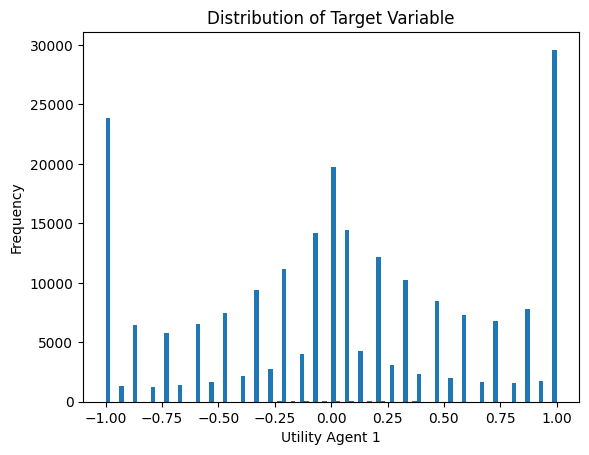

In [7]:
plt.hist(df_train['utility_agent1'], bins=100)
plt.title('Distribution of Target Variable')
plt.xlabel('Utility Agent 1')
plt.ylabel('Frequency')
plt.show()

In [8]:
split1 = pickle.load(open('../data/splits/cv1_Game.pkl', 'rb'))
split2 = pickle.load(open('../data/splits/cv2_Game.pkl', 'rb'))
split3 = pickle.load(open('../data/splits/cv3_Game.pkl', 'rb'))

# split1 = pickle.load(open('../data/splits/cv1_GameRulesetName.pkl', 'rb'))
# split2 = pickle.load(open('../data/splits/cv2_GameRulesetName.pkl', 'rb'))
# split3 = pickle.load(open('../data/splits/cv3_GameRulesetName.pkl', 'rb'))

***
### train model


In [9]:
if train_type == "small":
    LEARNING_RATE = 0.03
    NUM_BOOST_ROUND = 2500
elif train_type == "medium":
    LEARNING_RATE = 0.01
    NUM_BOOST_ROUND = 5000
elif train_type == "large":
    LEARNING_RATE = 0.005
    NUM_BOOST_ROUND = 10_000
elif train_type == "xlarge":
    LEARNING_RATE = 0.001
    NUM_BOOST_ROUND = 20_000


print(LEARNING_RATE, NUM_BOOST_ROUND)

0.03 2500


In [10]:
def train_models(
        df_train,
        target,
        numerical_cols,
        categorical_cols,
        split_list=None
    ):
    # Define the parameters
    params = {
        'objective': "reg:squarederror",
        'eval_metric': 'rmse',
        'max_depth': 8,
        'max_bin': 128,
        'learning_rate': LEARNING_RATE,
        'alpha': 0.1,
        'colsample_bytree': 0.5,
        'subsample': 0.8,
        'min_child_weight': 10,
        'seed': 2112,
        'verbosity': 0,
    }

    trained_models = []
    oof = pd.DataFrame(
        index=df_train.index,
        columns=[f'{target}_true', f'{target}_pred', 'fold']
    )
    oof_scores = []
    feat_importance_dfs = []

    # Perform cross-validation
    for fold, (train_index, val_index) in enumerate(split_list, 1):
        print(f"Fold {fold}")
        
        # Split the data
        X_train, X_val = df_train.iloc[train_index], df_train.iloc[val_index]
        y_train, y_val = X_train[target], X_val[target]

        feature_types = [
            "c" if col in categorical_cols else "q" 
            for col in numerical_cols + categorical_cols
        ]
        
        # Convert to DMatrix format
        train_data = xgb.DMatrix(
            data=X_train[numerical_cols + categorical_cols],
            label=y_train,
            feature_types=feature_types,
            enable_categorical=True,
            feature_names=numerical_cols + categorical_cols
        )
        val_data = xgb.DMatrix(
            data=X_val[numerical_cols + categorical_cols],
            label=y_val,
            feature_types=feature_types,
            enable_categorical=True,
            feature_names=numerical_cols + categorical_cols
        )

        # Train the model
        model = xgb.train(
            params,
            train_data,
            num_boost_round=NUM_BOOST_ROUND,
            evals=[(val_data, 'val')],
            verbose_eval=100,
        )
        
        # Get feature importance
        importance_dict = model.get_score(importance_type='gain')
        feat_importance = pd.DataFrame(
            {'feature': list(importance_dict.keys()),
             f'importance_f{fold}': list(importance_dict.values())}
        )
        feat_importance_dfs.append(feat_importance)
        
        # Save the trained model to the list
        trained_models.append(model)

        # predict on validation set
        y_pred = model.predict(val_data)

        # Save out-of-fold predictions
        oof.loc[val_index, f'{target}_true'] = y_val
        oof.loc[val_index, f'{target}_pred'] = y_pred
        oof.loc[val_index, 'fold'] = fold

        # Compute RMSE
        y_pred = np.clip(y_pred, -1, 1)
        rmse = np.sqrt(np.mean((y_pred - y_val) ** 2))
        print(f"Fold {fold} - RMSE: {rmse}")

        # Save RMSE to the list
        oof_scores.append(rmse)

    # Combine feature importance dataframes
    importance_df = feat_importance_dfs[0]
    for df in feat_importance_dfs[1:]:
        importance_df = importance_df.merge(df, on='feature')
    
    # Calculate mean importance across folds
    importance_cols = [col for col in importance_df.columns if col.startswith('importance_f')]
    importance_df['importance_mean'] = importance_df[importance_cols].mean(axis=1)
    importance_df = importance_df.sort_values('importance_mean', ascending=False, ignore_index=True)
    importance_df['importance_relative'] = (
        importance_df['importance_mean'] / 
        importance_df['importance_mean'].sum()
    )

    # Print the list of oof scores and average oof score
    print("List of oof scores:", oof_scores)
    print("Average oof score:", np.mean(oof_scores))

    return trained_models, oof, oof_scores, importance_df

In [11]:
# call the function
trained_models1, oof1, oof_scores1, importance_df1 = train_models(
    df_train,
    'utility_agent1',
    numerical_cols,
    categorical_cols,
    split_list=split1,
)
# save oof predictions
oof1.to_parquet(path_results / f'oof_xgboost_{fs_type}_cv1.parquet', index=False)

Fold 1


[0]	val-rmse:0.55397


[100]	val-rmse:0.47216


[200]	val-rmse:0.45631


[300]	val-rmse:0.44892


[400]	val-rmse:0.44418


[500]	val-rmse:0.44162


[600]	val-rmse:0.43980


[700]	val-rmse:0.43851


[800]	val-rmse:0.43786


[900]	val-rmse:0.43707


[1000]	val-rmse:0.43679


[1100]	val-rmse:0.43667


[1200]	val-rmse:0.43662


[1300]	val-rmse:0.43651


[1400]	val-rmse:0.43652


[1500]	val-rmse:0.43653


[1600]	val-rmse:0.43647


[1700]	val-rmse:0.43641


[1800]	val-rmse:0.43647


[1900]	val-rmse:0.43652


[2000]	val-rmse:0.43656


[2100]	val-rmse:0.43652


[2200]	val-rmse:0.43661


[2300]	val-rmse:0.43657


[2400]	val-rmse:0.43666


[2499]	val-rmse:0.43676


Fold 1 - RMSE: 0.4364493020866064
Fold 2


[0]	val-rmse:0.58724


[100]	val-rmse:0.48244


[200]	val-rmse:0.46775


[300]	val-rmse:0.46105


[400]	val-rmse:0.45617


[500]	val-rmse:0.45338


[600]	val-rmse:0.45166


[700]	val-rmse:0.45066


[800]	val-rmse:0.44970


[900]	val-rmse:0.44929


[1000]	val-rmse:0.44876


[1100]	val-rmse:0.44808


[1200]	val-rmse:0.44754


[1300]	val-rmse:0.44720


[1400]	val-rmse:0.44684


[1500]	val-rmse:0.44668


[1600]	val-rmse:0.44655


[1700]	val-rmse:0.44637


[1800]	val-rmse:0.44624


[1900]	val-rmse:0.44615


[2000]	val-rmse:0.44616


[2100]	val-rmse:0.44619


[2200]	val-rmse:0.44618


[2300]	val-rmse:0.44622


[2400]	val-rmse:0.44615


[2499]	val-rmse:0.44600


Fold 2 - RMSE: 0.4457074810480436
Fold 3


[0]	val-rmse:0.60381


[100]	val-rmse:0.47714


[200]	val-rmse:0.45734


[300]	val-rmse:0.44897


[400]	val-rmse:0.44468


[500]	val-rmse:0.44249


[600]	val-rmse:0.44057


[700]	val-rmse:0.43911


[800]	val-rmse:0.43845


[900]	val-rmse:0.43762


[1000]	val-rmse:0.43697


[1100]	val-rmse:0.43661


[1200]	val-rmse:0.43624


[1300]	val-rmse:0.43607


[1400]	val-rmse:0.43603


[1500]	val-rmse:0.43593


[1600]	val-rmse:0.43591


[1700]	val-rmse:0.43578


[1800]	val-rmse:0.43566


[1900]	val-rmse:0.43564


[2000]	val-rmse:0.43566


[2100]	val-rmse:0.43571


[2200]	val-rmse:0.43557


[2300]	val-rmse:0.43560


[2400]	val-rmse:0.43559


[2499]	val-rmse:0.43564


Fold 3 - RMSE: 0.4351949687365909
Fold 4


[0]	val-rmse:0.59557


[100]	val-rmse:0.47651


[200]	val-rmse:0.45522


[300]	val-rmse:0.44634


[400]	val-rmse:0.44101


[500]	val-rmse:0.43767


[600]	val-rmse:0.43572


[700]	val-rmse:0.43403


[800]	val-rmse:0.43293


[900]	val-rmse:0.43187


[1000]	val-rmse:0.43116


[1100]	val-rmse:0.43059


[1200]	val-rmse:0.43020


[1300]	val-rmse:0.42973


[1400]	val-rmse:0.42942


[1500]	val-rmse:0.42920


[1600]	val-rmse:0.42893


[1700]	val-rmse:0.42873


[1800]	val-rmse:0.42868


[1900]	val-rmse:0.42857


[2000]	val-rmse:0.42844


[2100]	val-rmse:0.42837


[2200]	val-rmse:0.42834


[2300]	val-rmse:0.42838


[2400]	val-rmse:0.42838


[2499]	val-rmse:0.42840


Fold 4 - RMSE: 0.4280842414764398
Fold 5


[0]	val-rmse:0.54839


[100]	val-rmse:0.45658


[200]	val-rmse:0.43719


[300]	val-rmse:0.42773


[400]	val-rmse:0.42092


[500]	val-rmse:0.41792


[600]	val-rmse:0.41575


[700]	val-rmse:0.41440


[800]	val-rmse:0.41345


[900]	val-rmse:0.41262


[1000]	val-rmse:0.41209


[1100]	val-rmse:0.41166


[1200]	val-rmse:0.41106


[1300]	val-rmse:0.41078


[1400]	val-rmse:0.41049


[1500]	val-rmse:0.41043


[1600]	val-rmse:0.41037


[1700]	val-rmse:0.41018


[1800]	val-rmse:0.41016


[1900]	val-rmse:0.41010


[2000]	val-rmse:0.40996


[2100]	val-rmse:0.41009


[2200]	val-rmse:0.41016


[2300]	val-rmse:0.41017


[2400]	val-rmse:0.41027


[2499]	val-rmse:0.41035


Fold 5 - RMSE: 0.4101157005625727
List of oof scores: [0.4364493020866064, 0.4457074810480436, 0.4351949687365909, 0.4280842414764398, 0.4101157005625727]
Average oof score: 0.43111033878205063


In [12]:
# call the function
trained_models2, oof2, oof_scores2, importance_df2 = train_models(
    df_train,
    'utility_agent1',
    numerical_cols,
    categorical_cols,
    split_list=split2,
)
# save oof predictions
oof2.to_parquet(path_results / f'oof_xgboost_{fs_type}_cv2.parquet', index=False)

Fold 1


[0]	val-rmse:0.53585


[100]	val-rmse:0.45693


[200]	val-rmse:0.44210


[300]	val-rmse:0.43588


[400]	val-rmse:0.43156


[500]	val-rmse:0.42967


[600]	val-rmse:0.42870


[700]	val-rmse:0.42782


[800]	val-rmse:0.42726


[900]	val-rmse:0.42679


[1000]	val-rmse:0.42640


[1100]	val-rmse:0.42606


[1200]	val-rmse:0.42576


[1300]	val-rmse:0.42541


[1400]	val-rmse:0.42531


[1500]	val-rmse:0.42511


[1600]	val-rmse:0.42508


[1700]	val-rmse:0.42501


[1800]	val-rmse:0.42487


[1900]	val-rmse:0.42480


[2000]	val-rmse:0.42471


[2100]	val-rmse:0.42477


[2200]	val-rmse:0.42471


[2300]	val-rmse:0.42463


[2400]	val-rmse:0.42464


[2499]	val-rmse:0.42458


Fold 1 - RMSE: 0.4242811845466035
Fold 2


[0]	val-rmse:0.54624


[100]	val-rmse:0.43763


[200]	val-rmse:0.42414


[300]	val-rmse:0.41939


[400]	val-rmse:0.41599


[500]	val-rmse:0.41406


[600]	val-rmse:0.41287


[700]	val-rmse:0.41238


[800]	val-rmse:0.41213


[900]	val-rmse:0.41162


[1000]	val-rmse:0.41129


[1100]	val-rmse:0.41117


[1200]	val-rmse:0.41108


[1300]	val-rmse:0.41103


[1400]	val-rmse:0.41086


[1500]	val-rmse:0.41093


[1600]	val-rmse:0.41090


[1700]	val-rmse:0.41101


[1800]	val-rmse:0.41114


[1900]	val-rmse:0.41121


[2000]	val-rmse:0.41137


[2100]	val-rmse:0.41144


[2200]	val-rmse:0.41165


[2300]	val-rmse:0.41176


[2400]	val-rmse:0.41182


[2499]	val-rmse:0.41187


Fold 2 - RMSE: 0.4115959182801204
Fold 3


[0]	val-rmse:0.61233


[100]	val-rmse:0.48770


[200]	val-rmse:0.46357


[300]	val-rmse:0.45341


[400]	val-rmse:0.44625


[500]	val-rmse:0.44224


[600]	val-rmse:0.43986


[700]	val-rmse:0.43798


[800]	val-rmse:0.43670


[900]	val-rmse:0.43571


[1000]	val-rmse:0.43488


[1100]	val-rmse:0.43433


[1200]	val-rmse:0.43391


[1300]	val-rmse:0.43335


[1400]	val-rmse:0.43310


[1500]	val-rmse:0.43291


[1600]	val-rmse:0.43279


[1700]	val-rmse:0.43255


[1800]	val-rmse:0.43243


[1900]	val-rmse:0.43235


[2000]	val-rmse:0.43208


[2100]	val-rmse:0.43194


[2200]	val-rmse:0.43195


[2300]	val-rmse:0.43192


[2400]	val-rmse:0.43191


[2499]	val-rmse:0.43178


Fold 3 - RMSE: 0.4314735123951196
Fold 4


[0]	val-rmse:0.60493


[100]	val-rmse:0.48478


[200]	val-rmse:0.46242


[300]	val-rmse:0.45279


[400]	val-rmse:0.44747


[500]	val-rmse:0.44429


[600]	val-rmse:0.44233


[700]	val-rmse:0.44079


[800]	val-rmse:0.43981


[900]	val-rmse:0.43902


[1000]	val-rmse:0.43858


[1100]	val-rmse:0.43801


[1200]	val-rmse:0.43757


[1300]	val-rmse:0.43726


[1400]	val-rmse:0.43690


[1500]	val-rmse:0.43673


[1600]	val-rmse:0.43650


[1700]	val-rmse:0.43625


[1800]	val-rmse:0.43610


[1900]	val-rmse:0.43603


[2000]	val-rmse:0.43582


[2100]	val-rmse:0.43575


[2200]	val-rmse:0.43566


[2300]	val-rmse:0.43571


[2400]	val-rmse:0.43571


[2499]	val-rmse:0.43574


Fold 4 - RMSE: 0.43533993630837686
Fold 5


[0]	val-rmse:0.59087


[100]	val-rmse:0.48808


[200]	val-rmse:0.46519


[300]	val-rmse:0.45566


[400]	val-rmse:0.44929


[500]	val-rmse:0.44537


[600]	val-rmse:0.44290


[700]	val-rmse:0.44139


[800]	val-rmse:0.44008


[900]	val-rmse:0.43944


[1000]	val-rmse:0.43872


[1100]	val-rmse:0.43806


[1200]	val-rmse:0.43776


[1300]	val-rmse:0.43733


[1400]	val-rmse:0.43703


[1500]	val-rmse:0.43685


[1600]	val-rmse:0.43660


[1700]	val-rmse:0.43656


[1800]	val-rmse:0.43657


[1900]	val-rmse:0.43661


[2000]	val-rmse:0.43658


[2100]	val-rmse:0.43656


[2200]	val-rmse:0.43638


[2300]	val-rmse:0.43636


[2400]	val-rmse:0.43636


[2499]	val-rmse:0.43641


Fold 5 - RMSE: 0.43603388525604375
List of oof scores: [0.4242811845466035, 0.4115959182801204, 0.4314735123951196, 0.43533993630837686, 0.43603388525604375]
Average oof score: 0.4277448873572528


In [13]:
# call the function
trained_models3, oof3, oof_scores3, importance_df3 = train_models(
    df_train,
    'utility_agent1',
    numerical_cols,
    categorical_cols,
    split_list=split3,
)
# save oof predictions
oof3.to_parquet(path_results / f'oof_xgboost_{fs_type}_cv3.parquet', index=False)

Fold 1


[0]	val-rmse:0.57529


[100]	val-rmse:0.47796


[200]	val-rmse:0.45880


[300]	val-rmse:0.45147


[400]	val-rmse:0.44717


[500]	val-rmse:0.44445


[600]	val-rmse:0.44282


[700]	val-rmse:0.44180


[800]	val-rmse:0.44105


[900]	val-rmse:0.44026


[1000]	val-rmse:0.43969


[1100]	val-rmse:0.43933


[1200]	val-rmse:0.43922


[1300]	val-rmse:0.43914


[1400]	val-rmse:0.43878


[1500]	val-rmse:0.43862


[1600]	val-rmse:0.43857


[1700]	val-rmse:0.43851


[1800]	val-rmse:0.43842


[1900]	val-rmse:0.43841


[2000]	val-rmse:0.43841


[2100]	val-rmse:0.43829


[2200]	val-rmse:0.43835


[2300]	val-rmse:0.43831


[2400]	val-rmse:0.43835


[2499]	val-rmse:0.43833


Fold 1 - RMSE: 0.4380876053602187
Fold 2


[0]	val-rmse:0.57461


[100]	val-rmse:0.47623


[200]	val-rmse:0.45736


[300]	val-rmse:0.44840


[400]	val-rmse:0.44232


[500]	val-rmse:0.43841


[600]	val-rmse:0.43575


[700]	val-rmse:0.43431


[800]	val-rmse:0.43336


[900]	val-rmse:0.43225


[1000]	val-rmse:0.43150


[1100]	val-rmse:0.43092


[1200]	val-rmse:0.43045


[1300]	val-rmse:0.43018


[1400]	val-rmse:0.42993


[1500]	val-rmse:0.42975


[1600]	val-rmse:0.42960


[1700]	val-rmse:0.42955


[1800]	val-rmse:0.42929


[1900]	val-rmse:0.42912


[2000]	val-rmse:0.42913


[2100]	val-rmse:0.42910


[2200]	val-rmse:0.42911


[2300]	val-rmse:0.42908


[2400]	val-rmse:0.42895


[2499]	val-rmse:0.42890


Fold 2 - RMSE: 0.4286018723519235
Fold 3


[0]	val-rmse:0.57638


[100]	val-rmse:0.46800


[200]	val-rmse:0.45118


[300]	val-rmse:0.44387


[400]	val-rmse:0.43881


[500]	val-rmse:0.43601


[600]	val-rmse:0.43435


[700]	val-rmse:0.43330


[800]	val-rmse:0.43250


[900]	val-rmse:0.43174


[1000]	val-rmse:0.43124


[1100]	val-rmse:0.43061


[1200]	val-rmse:0.43028


[1300]	val-rmse:0.43006


[1400]	val-rmse:0.42989


[1500]	val-rmse:0.42973


[1600]	val-rmse:0.42959


[1700]	val-rmse:0.42930


[1800]	val-rmse:0.42914


[1900]	val-rmse:0.42914


[2000]	val-rmse:0.42894


[2100]	val-rmse:0.42887


[2200]	val-rmse:0.42887


[2300]	val-rmse:0.42893


[2400]	val-rmse:0.42889


[2499]	val-rmse:0.42889


Fold 3 - RMSE: 0.4286110017197552
Fold 4


[0]	val-rmse:0.57455


[100]	val-rmse:0.46543


[200]	val-rmse:0.44724


[300]	val-rmse:0.43955


[400]	val-rmse:0.43530


[500]	val-rmse:0.43304


[600]	val-rmse:0.43107


[700]	val-rmse:0.43000


[800]	val-rmse:0.42939


[900]	val-rmse:0.42879


[1000]	val-rmse:0.42844


[1100]	val-rmse:0.42789


[1200]	val-rmse:0.42749


[1300]	val-rmse:0.42696


[1400]	val-rmse:0.42663


[1500]	val-rmse:0.42643


[1600]	val-rmse:0.42635


[1700]	val-rmse:0.42628


[1800]	val-rmse:0.42622


[1900]	val-rmse:0.42621


[2000]	val-rmse:0.42613


[2100]	val-rmse:0.42615


[2200]	val-rmse:0.42603


[2300]	val-rmse:0.42605


[2400]	val-rmse:0.42602


[2499]	val-rmse:0.42600


Fold 4 - RMSE: 0.42564915422659777
Fold 5


[0]	val-rmse:0.58569


[100]	val-rmse:0.47353


[200]	val-rmse:0.45351


[300]	val-rmse:0.44330


[400]	val-rmse:0.43686


[500]	val-rmse:0.43368


[600]	val-rmse:0.43099


[700]	val-rmse:0.42943


[800]	val-rmse:0.42788


[900]	val-rmse:0.42687


[1000]	val-rmse:0.42612


[1100]	val-rmse:0.42553


[1200]	val-rmse:0.42501


[1300]	val-rmse:0.42451


[1400]	val-rmse:0.42396


[1500]	val-rmse:0.42371


[1600]	val-rmse:0.42341


[1700]	val-rmse:0.42308


[1800]	val-rmse:0.42310


[1900]	val-rmse:0.42305


[2000]	val-rmse:0.42293


[2100]	val-rmse:0.42271


[2200]	val-rmse:0.42256


[2300]	val-rmse:0.42253


[2400]	val-rmse:0.42238


[2499]	val-rmse:0.42233


Fold 5 - RMSE: 0.42197782166396236
List of oof scores: [0.4380876053602187, 0.4286018723519235, 0.4286110017197552, 0.42564915422659777, 0.42197782166396236]
Average oof score: 0.42858549106449145


In [14]:
# Print summary of OOF scores for each CV fold
print("CV1 OOF Scores:")
for score in oof_scores1:
    print(f"Score: {score:.4f}")
print(f"Average CV1 Score: {sum(oof_scores1)/len(oof_scores1):.4f}")
    
print("\nCV2 OOF Scores:")  
for score in oof_scores2:
    print(f"Score: {score:.4f}")
print(f"Average CV2 Score: {sum(oof_scores2)/len(oof_scores2):.4f}")
    
print("\nCV3 OOF Scores:")
for score in oof_scores3:
    print(f"Score: {score:.4f}")
print(f"Average CV3 Score: {sum(oof_scores3)/len(oof_scores3):.4f}")

CV1 OOF Scores:
Score: 0.4364
Score: 0.4457
Score: 0.4352
Score: 0.4281
Score: 0.4101
Average CV1 Score: 0.4311

CV2 OOF Scores:
Score: 0.4243
Score: 0.4116
Score: 0.4315
Score: 0.4353
Score: 0.4360
Average CV2 Score: 0.4277

CV3 OOF Scores:
Score: 0.4381
Score: 0.4286
Score: 0.4286
Score: 0.4256
Score: 0.4220
Average CV3 Score: 0.4286


In [15]:
trained_models = [*trained_models1, *trained_models2, *trained_models3]
# trained_models = trained_models1

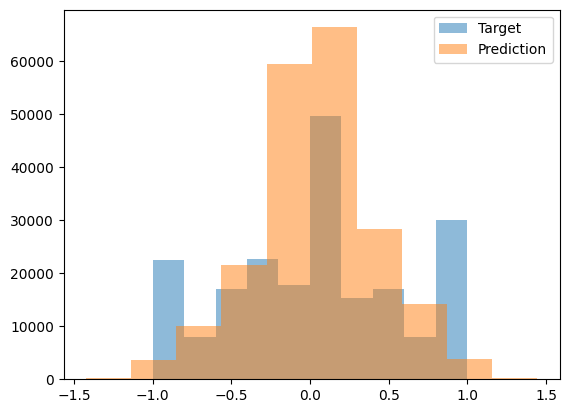

In [16]:
plt.hist(oof1['utility_agent1_true'], alpha=0.5, label='Target')
plt.hist(oof1['utility_agent1_pred'], alpha=0.5, label='Prediction')
plt.legend()
plt.show()

***
### inference

In [17]:
import os
import polars as pl
sys.path.append("../data/raw/")
import kaggle_evaluation.mcts_inference_server

In [18]:
def predict(test: pl.DataFrame, sample_sub: pl.DataFrame):
    # Convert Polars DataFrame to Pandas DataFrame
    test_pd = test.to_pandas()
    
    # Process the test data
    test_processed = process_test_data(
        test_pd,
        numerical_cols,
        categorical_cols,
        encoder,
        scaler
    )

    # Create feature types list for XGBoost
    feature_types = [
        "c" if col in categorical_cols else "q" 
        for col in numerical_cols + categorical_cols
    ]

    # Create XGBoost DMatrix for test data
    test_dmatrix = xgb.DMatrix(
        data=test_processed[numerical_cols + categorical_cols],
        feature_types=feature_types,
        enable_categorical=True
    )

    # Average predictions from all models
    predictions = np.mean([
        model.predict(test_dmatrix)
        for model in trained_models
    ], axis=0)
    predictions = np.clip(predictions, -1, 1)
        
    # Create the submission DataFrame
    submission = sample_sub.with_columns(pl.Series("utility_agent1", predictions))
    
    return submission

In [19]:
inference_server = kaggle_evaluation.mcts_inference_server.MCTSInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server.serve()
else:
    inference_server.run_local_gateway(
        (
            '../data/raw/test.csv',
            '../data/raw/sample_submission.csv'
        )
    )

In [20]:
# Save all artifacts needed for prediction
xgboost_predict = {
    'models': trained_models,
    'numerical_cols': numerical_cols,
    'categorical_cols': categorical_cols,
    'encoder': encoder,
    'scaler': scaler
}

with open(f'./xgboost_predict_{fs_type}.pkl', 'wb') as f:
    pickle.dump(xgboost_predict, f)

***